In [1]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# import local functions
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from functions.author_fns import Author, compare_nets

%matplotlib inline

## Load data

In [2]:
method = 'florida'
node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
g = igraph.load('../data/florida_coa_graph',format='pickle')

## Parameter distributions and constants

#### Thresholds and constants

In [18]:
nAuth = 500
learn_thr = .1
c = 3
diam = 3
net_size = 500
bib_length = 70
woman_perc = sum([x['gender'] == 'woman' for x in node_2_gender.values()])/len(node_2_gender)
colors = ['#d97d5b', '#4a3b90', '#5295d0', '#fabc50']

#### Netbias
Max shows that coauthorship is a modest predictor of over/under citation. 10% overinfluence for MM,, close to even for WW

In [19]:
# parameters (mean, stdev) for each distribution
net_w = (.5,.1)
net_m = (.4,.1)

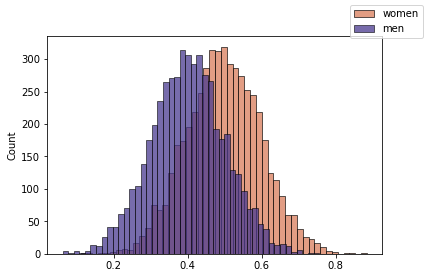

In [20]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=net_w[0],scale=net_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=net_m[0],scale=net_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

#### Walk bias
Taken from jordans paper, MM cite WW teams about 25% less than you would expect. WW overcite 10%

In [21]:
walk_w = (.55,.05)
walk_m = (.30,.05)

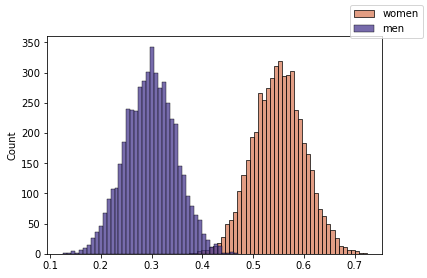

In [22]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

#### Meet bias
People in the majority are less interdisciplinary, men invite women ot meetings less

In [23]:
meet_w = (0.025,0.005)
meet_m = (0.035,0.005)

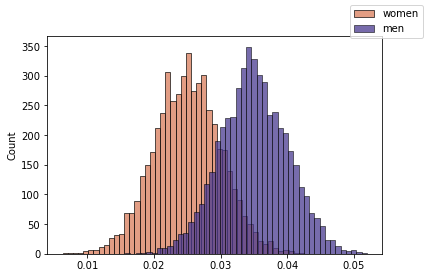

In [24]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_w[0],scale=meet_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=meet_m[0],scale=meet_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

People might tend to meet with people who share similar values (i.e. biases)

In [25]:
meetb_w = (0.3,0.05)
meetb_m = (0.2,0.05)

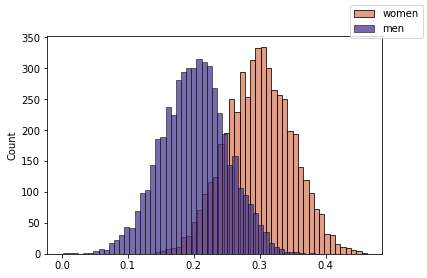

In [26]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meetb_w[0],scale=meetb_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=meetb_m[0],scale=meetb_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

#### Learn bias
Mean taken from Chris's paper. Adam Grant paper about talking over women (20%)

In [27]:
learn_w = (-.5,.75)
learn_m = (-1,.75)

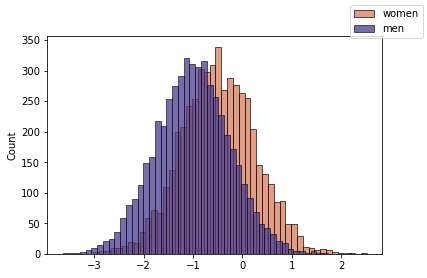

In [28]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.log(np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=5000)), color=colors[0])
sns.histplot(np.log(np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=5000)), color=colors[1])
f.legend(labels=['women','men'])

#### Forget bias

Men not taught to be as ciritcal and update network less?

In [29]:
forget_w = (.75,.1)
forget_m = (.5,.1)

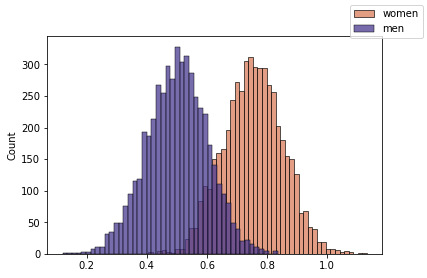

In [30]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.log(np.random.lognormal(mean=forget_w[0],sigma=forget_w[1],size=5000)), color=colors[0])
sns.histplot(np.log(np.random.lognormal(mean=forget_m[0],sigma=forget_m[1],size=5000)), color=colors[1])
f.legend(labels=['women','men'])

## Simulations


#### Social

In [31]:
# generate authors
authors = []
for i in range(nAuth):
    if np.random.rand(1)[0] >= woman_perc:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
        forget = np.random.lognormal(mean=forget_m[0],sigma=forget_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
        forget = np.random.lognormal(mean=forget_w[0],sigma=forget_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,forget,gen)
    a.init_network(g,node_2_gender,net_size,diam,c)
    authors.append(a)


In [ ]:
# group meeting function
def group_meet():
    for j in range(nAuth):
        # pick author for meeting
        k = np.random.choice(range(nAuth))
        
        # check if at least one will meet
        [m12,m21] = compare_nets(authors[j], authors[k])
        if any([m12,m21]):
            # if yes, update the network
            if m12:
                bib = authors[k].get_cites(bib_length)
                authors[j].update_network(bib, authors[k].network, learn_thr)
            if m21:
                bib = authors[j].get_cites(bib_length)
                authors[k].update_network(bib, authors[j].network, learn_thr)
        # forget
        authors[j].forget()
        authors[k].forget()
        # log information
        # update meets
        meets[j] = {'gender1': authors[j].gender, 'gender2':authors[k].gender, 'meet12':m12, 'meet21':m21}
    
    # get network size
    net_size.append(np.mean([len(a.memory) for a in authors]))
    # update cites
    bibs = [a.get_cites(bib_length) for a in authors]
    bibs_w = [b for i,b in enumerate(bibs) if w_index[i]]
    bibs_m = [b for i,b in enumerate(bibs) if not(w_index[i])]
    cite_perc = (np.mean([cite['gender'] == 'woman' for b in bibs for cite in b.values()]),
                         np.std([cite['gender'] == 'woman' for b in bibs for cite in b.values()]))
    cite_perc_w = (np.mean([cite['gender'] == 'woman' for b in bibs_w for cite in b.values()]),
                           np.std([cite['gender'] == 'woman' for b in bibs_w for cite in b.values()]))
    cite_perc_m = (np.mean([cite['gender'] == 'woman' for b in bibs_m for cite in b.values()]),
                           np.std([cite['gender'] == 'woman' for b in bibs_m for cite in b.values()]))
    
    return meets, cite_perc, cite_perc_w, cite_perc_m
    

# simulate meetings
nMeetings = 250
meets = {}; # keep track of when meetings were successful
citation_perc = [];
citation_perc_w = [];
citation_perc_m = [];
net_size = [];
w_index = [a.gender == 'W' for a in authors]

# run simulation
data = Parallel(n_jobs=4)(
    delayed(group_meet)()
    for b in tqdm(range(nMeetings)) 
)

In [87]:
# reformat data
for i,d in enumerate(data):    
    curr_meets, cite_perc, cite_perc_w, cite_perc_m = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    citation_perc.append(cite_perc)
    citation_perc_w.append(cite_perc_w)
    citation_perc_m.append(cite_perc_m)

In [86]:
# network size

125500

Text(0.5, 1.0, 'Different Gender Meetings')

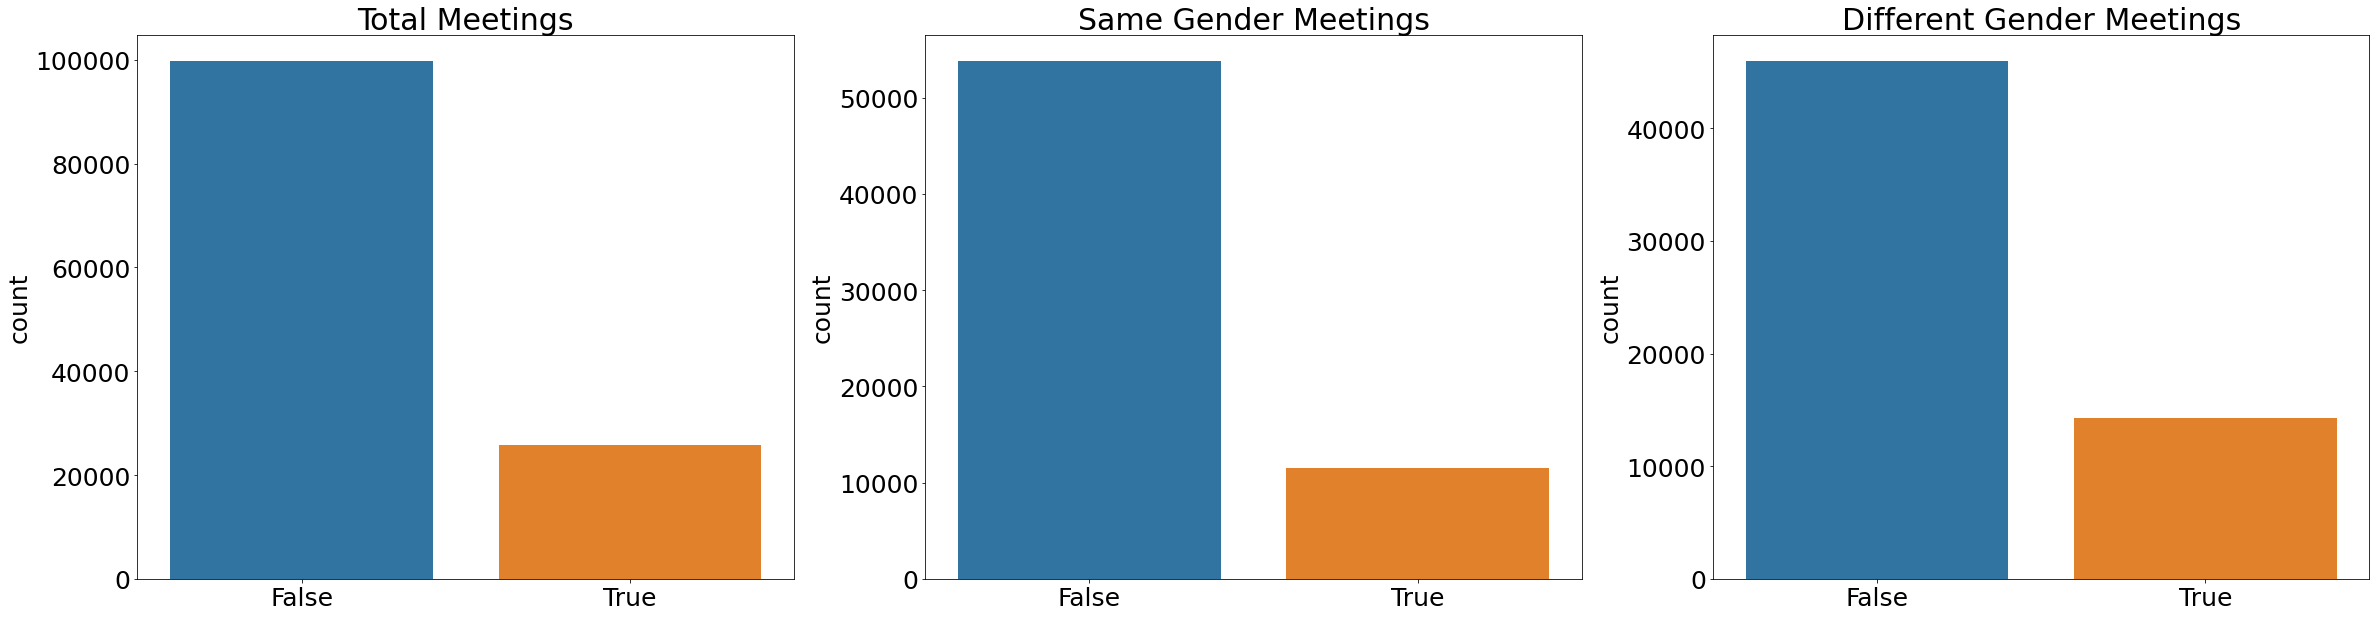

In [90]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

Text(0.5, 1.0, 'Percentage citation of women')

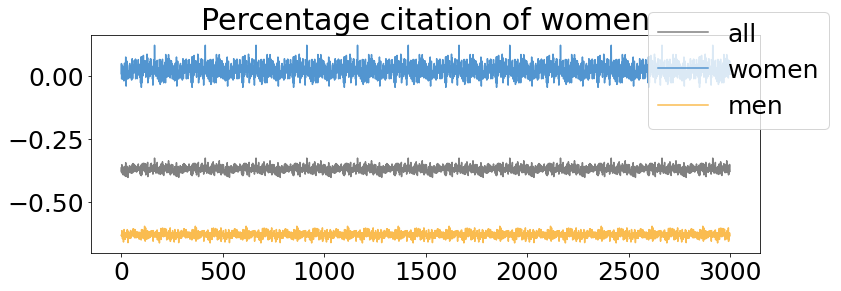

In [92]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=(np.array([x[0] for x in citation_perc])/woman_perc) - 1, color='grey',ax=ax)
sns.lineplot(data=(np.array([x[0] for x in citation_perc_w])/woman_perc) - 1, color=colors[2],ax=ax)
sns.lineplot(data=(np.array([x[0] for x in citation_perc_m])/woman_perc) - 1, color=colors[3],ax=ax)
f.legend(labels=['all','women','men'])
ax.set_title('Percentage citation of women')

Text(0.5, 1.0, 'Womens Citation Practices')

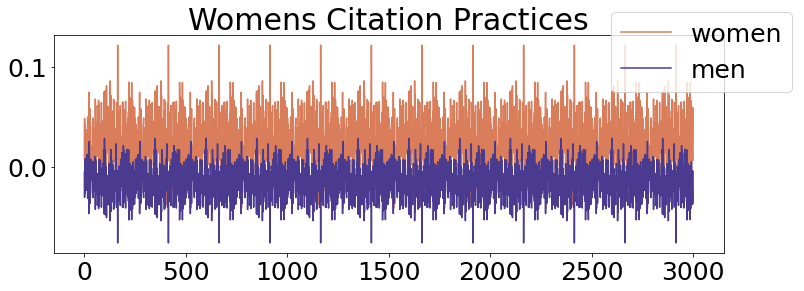

In [93]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array([x[0] for x in citation_perc_w]) - woman_perc)/woman_perc), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array([x[0] for x in citation_perc_w])) - (1 - woman_perc))/(1 - woman_perc), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Womens Citation Practices')

Text(0.5, 1.0, 'Mens Citation Practices')

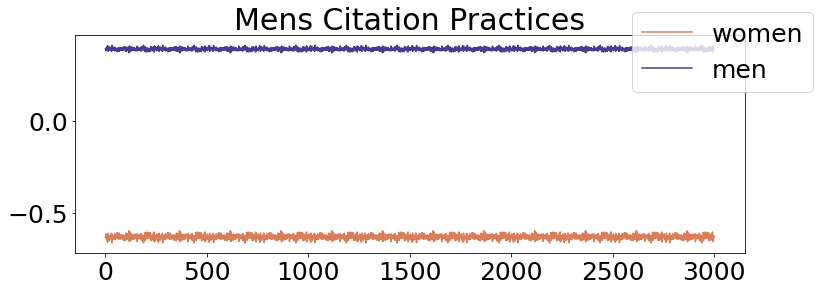

In [97]:
# always adding, always going towards the mean. maybe we need a forgetting mechanism
# at extremes, will these be driven apart
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array([x[0] for x in citation_perc_m]) - woman_perc)/woman_perc), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array([x[0] for x in citation_perc_m])) - (1 - woman_perc))/(1 - woman_perc), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Mens Citation Practices')

#### Bias

In [ ]:
# generate authors
authors = []
for i in range(nAuth):
    if np.random.rand(1)[0] >= woman_perc:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meetb_m[0],scale=meetb_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meetb_w[0],scale=meetb_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gen)
    a.init_network(g,node_2_gender,net_size,diam,c)
    authors.append(a)


In [ ]:
# simulate meetings
nMeetings = 10000
meets = {}; # keep track of when meetings were successful
citation_perc = [];
citation_perc_w = [];
citation_perc_m = [];
w_index = [a.gender == 'W' for a in authors]
# run simulation
for i in tqdm(range(nMeetings)):
    # draw random authors
    auths = np.random.choice(range(nAuth),2)
    
    # check if at least one will meet
    [m12,m21] = compare_nets(authors[auths[0]], authors[auths[1]],method='bi')
    if any([m12,m21]):
        # if yes, update the network
        if m12:
            bib = authors[auths[1]].get_cites(bib_length)
            authors[auths[0]].update_network(bib, authors[auths[1]].network, learn_thr)
        if m21:
            bib = authors[auths[0]].get_cites(bib_length)
            authors[auths[1]].update_network(bib, authors[auths[0]].network, learn_thr)
    # log information
    # update meets
    meets[i] = {'gender': authors[auths[0]].gender + authors[auths[1]].gender, 'meet':[m12,m21]}
    # update cites
    bibs = [a.get_cites(bib_length) for a in authors]
    bibs_w = [b for i,b in enumerate(bibs) if w_index[i]]
    bibs_m = [b for i,b in enumerate(bibs) if not(w_index[i])]
    citation_perc.append(np.mean([cite['gender'] == 'woman' for b in bibs for cite in b.values()]))
    citation_perc_w.append(np.mean([cite['gender'] == 'woman' for b in bibs_w for cite in b.values()]))
    citation_perc_m.append(np.mean([cite['gender'] == 'woman' for b in bibs_m for cite in b.values()]))

In [ ]:
# plots
sns.countplot([sum(x['meet']) for x in meets.values()])

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=(np.array(citation_perc)/woman_perc) - 1, color='grey',ax=ax)
sns.lineplot(data=(np.array(citation_perc_w)/woman_perc) - 1, color=colors[2],ax=ax)
sns.lineplot(data=(np.array(citation_perc_m)/woman_perc) - 1, color=colors[3],ax=ax)
f.legend(labels=['all','women','men'])
ax.set_title('Percentage citation of women')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array(citation_perc_w) - woman_perc)/woman_perc), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array(citation_perc_w)) - (1 - woman_perc))/(1 - woman_perc), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Womens Citation Practices')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array(citation_perc_m) - woman_perc)/woman_perc), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array(citation_perc_m)) - (1 - woman_perc))/(1 - woman_perc), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Mens Citation Practices')